In [1]:
from typing import List, Tuple, Dict, Any, Optional
from pandarallel import pandarallel
import os
import re
import sys
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [5]:
import sys
BASE_PATH = ".."
sys.path.append(BASE_PATH)

# v016 = LLM with API
# GENERATION_PATH_LLM_API = Path(
#     BASE_PATH, "program_bank/v016/2025_01_13__11_30__qiskit")
# GENERATION_PATH_LLM_API = Path(
#     BASE_PATH, "program_bank/v016/2025_01_13__11_47__qiskit")
# GENERATION_PATH_LLM_API = Path(
#     BASE_PATH, "program_bank/v016/2025_01_13__16_57__qiskit")

# v017 = LLM empty API
# GENERATION_PATH_LLM_API = Path(
#     BASE_PATH, "program_bank/v017/2025_01_13__23_51__qiskit")


GENERATION_PATH_W_API = Path(
    BASE_PATH, "program_bank/v016/2025_01_13__11_47__qiskit")
GENERATION_PATH_NO_API = Path(
    BASE_PATH, "program_bank/v017/2025_01_13__23_51__qiskit")

### Task description: Run Qiskit Scripts

**Objective:**
Develop a Python script to scan and run Qiskit scripts ending in `circuit.py` from a specified directory using two different versions of Qiskit Docker images. The script should log the results and errors for each version, generate a summary report, and visualize the error analysis.

**Requirements:**
1. **Directory Scanning:**
   - Scan the directory specified by the global variable `GENERATION_PATH_LLM_API` for all Python files ending with `circuit.py`.

2. **Running Qiskit Scripts:**
   - For each identified script, run it using two versions of Qiskit Docker images:
     - Version 1: `qiskit_image_1.2.0`
     - Version 2: `qiskit_image_0.45.0`
   - Use the `run_qiskit_code_in_docker` function from `aiexchange.tools.docker_tools` to execute the scripts.
   - Use `tqdm` to display progress information during script execution.

3. **Logging Results:**
   - Log the output and errors for each script run with both versions.
   - Store the logs in the same directory as the script with the following naming convention:
     - For version 1.2.0: `<program_name_without_py>_120.log`
     - For version 0.45.0: `<program_name_without_py>_045.log`

4. **Success Criteria:**
   - A script run is considered successful if `"traceback" not in logs.lower()` and `"SyntaxError" not in logs`.

5. **Summary Report:**
   - Generate a summary report indicating how many scripts successfully ran with both versions.
   - Store the summary report in the specified directory.
   - Create a routine at the end of the script to read all the logs into a Pandas DataFrame with the following columns:
     - `program_name`
     - `log_045`
     - `log_120`
     - `error_045` (contains either "syntax" or "runtime")
     - `error_120` (contains either "syntax" or "runtime")
     - `success_045` (boolean)
     - `success_120` (boolean)

6. **Error Analysis and Visualization:**
   - Count the number of syntax errors and other traceback errors for each version.
   - Plot a stacked histogram showing the number of syntax errors and other traceback errors for each version.


In [6]:
from aiexchange.tools.docker_tools import run_qiskit_code_in_docker

# Directory scanning


def scan_directory_for_scripts(directory: str) -> List[str]:
    return [str(path) for path in Path(directory).rglob('*circuit.py')]

# Running Qiskit scripts


def extract_version(image_name: str) -> str:
    ver_w_dots = re.search(
        r'qiskit_image_(\d+\.\d+\.\d+)', image_name).group(1)
    return ver_w_dots.replace('.', '')


def run_scripts(
        scripts_paths: List[Path],
        qiskit_image_name: str) -> Tuple[str]:
    logs = []
    for script_path in tqdm(
            scripts_paths, desc=f"Running scripts with Qiskit {qiskit_image_name}"):
        script_content = Path(script_path).read_text()
        # check if result was already computed
        ver_suffix = extract_version(qiskit_image_name)
        log_result = f"{Path(script_path).stem}_{ver_suffix}.log"
        if Path(script_path).parent / log_result in Path(script_path).parent.glob(
                f"*_{ver_suffix}.log"):
            with open(Path(script_path).parent / log_result, 'r') as f:
                log = f.read()
        else:
            log = run_qiskit_code_in_docker(script_content, qiskit_image_name)
            with open(Path(script_path).parent / log_result, 'w') as f:
                f.write(log)
        logs.append(log)
    return logs
# Summary report


def generate_summary_report(
        logs_045: Tuple[str],
        logs_120: Tuple[str]) -> pd.DataFrame:
    data = []
    for log_045, log_120 in zip(logs_045, logs_120):
        data.append(
            {'log_045': log_045, 'log_120': log_120})
    return pd.DataFrame(data)


def extract_error_type(log: str) -> str:
    match = re.search(r'(\w+Error)', log)
    if match:
        return match.group(1)
    return 'Correct'


def get_error_throwing_line(log: str) -> Optional[int]:
    match = re.search(r'File "/workspace/code_sample.py", line (\d+)', log)
    if match:
        return int(match.group(1))
    return None


def is_successful(log: str) -> bool:
    return "traceback" not in log.lower() and "SyntaxError" not in log and not "IndentationError" in log

In [7]:

def process_qiskit_scripts(generation_path: Path) -> pd.DataFrame:
    scripts_paths = scan_directory_for_scripts(generation_path)
    print(f"Found {len(scripts_paths)} scripts to run")

    logs_045 = run_scripts(
        scripts_paths, qiskit_image_name='qiskit_image_0.45.0')
    logs_120 = run_scripts(
        scripts_paths, qiskit_image_name='qiskit_image_1.2.0')
    summary_df = generate_summary_report(logs_045, logs_120)
    summary_df["program_name"] = [
        Path(script).stem for script in scripts_paths]
    summary_df = summary_df.sort_values(by="program_name")

    summary_df["metadata"] = summary_df["program_name"].apply(
        lambda name: json.dumps(
            json.load(
                open(
                    Path(
                        generation_path,
                        f"{name.replace('circuit', 'metadata')}.json"))),
            indent=4))

    summary_df['error_type_045'] = summary_df['log_045'].apply(
        extract_error_type)
    summary_df['error_type_120'] = summary_df['log_120'].apply(
        extract_error_type)

    summary_df['last_executed_row_045'] = summary_df['log_045'].apply(
        get_error_throwing_line).astype('Int64')
    summary_df['last_executed_row_120'] = summary_df['log_120'].apply(
        get_error_throwing_line).astype('Int64')

    summary_df["success_045"] = summary_df["log_045"].apply(is_successful)
    summary_df["success_120"] = summary_df["log_120"].apply(is_successful)

    summary_df.to_csv(
        Path(generation_path) / 'summary_report.csv', index=False)

    return summary_df


df_w_api = process_qiskit_scripts(
    generation_path=GENERATION_PATH_W_API)
df_no_api = process_qiskit_scripts(
    generation_path=GENERATION_PATH_NO_API)

# summary_df.to_csv(
#     Path(GENERATION_PATH_LLM_API) / 'summary_report.csv', index=False)

Found 100 scripts to run


Running scripts with Qiskit qiskit_image_0.45.0:   0%|          | 0/100 [00:00<?, ?it/s]

Running scripts with Qiskit qiskit_image_1.2.0:   0%|          | 0/100 [00:00<?, ?it/s]

Found 100 scripts to run


Running scripts with Qiskit qiskit_image_0.45.0:   0%|          | 0/100 [00:00<?, ?it/s]

Running scripts with Qiskit qiskit_image_1.2.0:   0%|          | 0/100 [00:00<?, ?it/s]

Percentage of corrects for Qiskit 0.45.0: 24.00%
Percentage of corrects for Qiskit 1.2.0: 25.00%


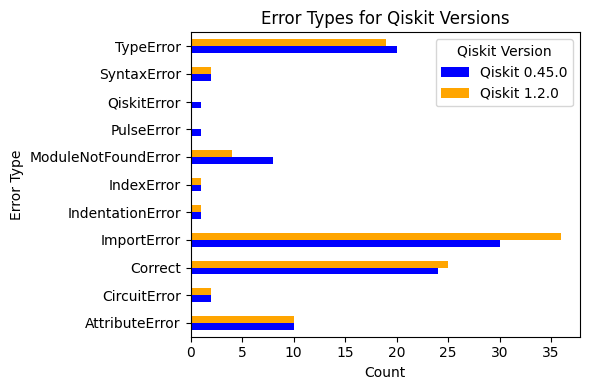

Percentage of corrects for Qiskit 0.45.0: 99.00%
Percentage of corrects for Qiskit 1.2.0: 23.00%


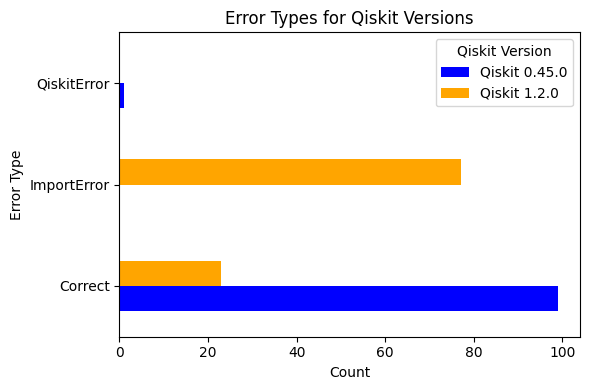

In [9]:
import re
import seaborn as sns


def show_error_types(df: pd.DataFrame, save_path: Optional[str] = None) -> Tuple[plt.Figure, plt.Axes]:
    # Plotting the error type counts for each version
    fig, ax = plt.subplots(figsize=(14, 7))

    # Get unique error types
    unique_error_types_045 = df['error_type_045'].unique()
    unique_error_types_120 = df['error_type_120'].unique()

    # Create palette
    palette_045 = {
        error_type: 'green'
        if error_type == 'Correct' else 'red'
        for error_type in unique_error_types_045}
    palette_120 = {
        error_type: 'green'
        if error_type == 'Correct' else 'red'
        for error_type in unique_error_types_120}

    # Plotting the error type counts for each version side by side
    error_counts_045 = df['error_type_045'].value_counts()
    error_counts_120 = df['error_type_120'].value_counts()

    # Create a DataFrame for plotting
    error_counts_df = pd.DataFrame({
        'Qiskit 0.45.0': error_counts_045,
        'Qiskit 1.2.0': error_counts_120
    }).fillna(0)

    error_counts_df.plot(
        kind='barh', figsize=(6, 4),
        color=['blue', 'orange'],
        ax=ax)
    ax.set_title('Error Types for Qiskit Versions')
    ax.set_ylabel('Error Type')
    ax.set_xlabel('Count')
    ax.legend(title='Qiskit Version')

    correct_045 = df['error_type_045'].value_counts().get('Correct', 0)
    correct_120 = df['error_type_120'].value_counts().get('Correct', 0)

    total_045 = len(df)
    total_120 = len(df)

    percentage_correct_045 = (correct_045 / total_045) * 100
    percentage_correct_120 = (correct_120 / total_120) * 100

    print(
        f"Percentage of corrects for Qiskit 0.45.0: {percentage_correct_045:.2f}%")
    print(
        f"Percentage of corrects for Qiskit 1.2.0: {percentage_correct_120:.2f}%")

    plt.tight_layout()

    if save_path:
        fig.savefig(save_path)

    plt.show()
    return fig, ax


# Example usage
fig, ax = show_error_types(
    df_w_api, save_path='images/error_types_w_api.png')
fig, ax = show_error_types(
    df_no_api, save_path='images/error_types_no_api.png')

In [24]:
from IPython.display import display, Markdown

max_to_show = 2


def pretty_print_summary(df: pd.DataFrame, max_to_show: int = 5):
    for index, row in df.head(max_to_show).iterrows():
        program_name = row['program_name']
        log_045 = row['log_045']
        log_120 = row['log_120']
        success_045 = row['success_045']
        success_120 = row['success_120']

        program_path = os.path.join(
            GENERATION_PATH_LLM_API, f"{program_name}.py")
        program_code = Path(program_path).read_text()
        display(Markdown(f"# {program_name}"))
        display(Markdown(f"## Code"))
        display(Markdown(f"```python\n{program_code}\n```"))
        display(Markdown(f"## Logs"))
        display(Markdown(f"### Qiskit 0.45.0"))
        display(Markdown(f"```\n{log_045}```"))
        display(Markdown(f"### Qiskit 1.2.0"))
        display(Markdown(f"```\n{log_120}```"))
        display(Markdown(f"## Metadata"))
        display(Markdown(f"```json\n{row['metadata']}\n```"))


df = summary_df[summary_df['error_type_045'] == 'Correct']
# df = summary_df[summary_df['error_type_120'] == 'Correct']
# df = summary_df[summary_df['error_type_045'] == 'ImportError']

pretty_print_summary(df, max_to_show)

# 0000011_ca8ef1_circuit

## Code

```python
from qiskit import QuantumCircuit
circuit = QuantumCircuit(2)
circuit.sx(0)
circuit.x(1)
print(circuit)
```

## Logs

### Qiskit 0.45.0

```
     ┌────┐
q_0: ┤ √X ├
     ├───┬┘
q_1: ┤ X ├─
     └───┘ 
```

### Qiskit 1.2.0

```
     ┌────┐
q_0: ┤ √X ├
     ├───┬┘
q_1: ┤ X ├─
     └───┘ 
```

## Metadata

```json
{
    "api_info": {
        "api_name": "sx",
        "full_api_name": "QuantumCircuit.sx",
        "api_description": "Apply :class:`~qiskit.circuit.library.SXGate`.\n\nFor the full matrix form of this gate, see the underlying gate documentation.\n\nArgs:\n    qubit: The qubit(s) to apply the gate to.\n\nReturns:\n    A handle to the instructions created.",
        "api_signature": "sx(self, qubit)",
        "file_path": "/usr/local/lib/python3.10/site-packages/qiskit/circuit/quantumcircuit.py"
    },
    "dspy_store": {
        "reasoning": "The provided API is QuantumCircuit.sx, which applies the SXGate to a qubit. To generate a program inspired by this API, we need to create a QuantumCircuit object, apply the sx gate to a qubit, and then use the resulting circuit.",
        "generated_python_program": "from qiskit import QuantumCircuit\ncircuit = QuantumCircuit(2)\ncircuit.sx(0)\ncircuit.x(1)\nprint(circuit)",
        "variable_name_of_circuit": "circuit"
    }
}
```

# 0000012_2bab55_circuit

## Code

```python
from qiskit import QuantumCircuit, execute, Aer
from qiskit.result import Counts

# Create a quantum circuit
qc = QuantumCircuit(2, 2)

# Add gates to the circuit
qc.h(0)
qc.cx(0, 1)
qc.measure([0, 1], [0, 1])

# Execute the circuit with a specified number of shots
job = execute(qc, Aer.get_backend('qasm_simulator'), shots=1024)
result = job.result()
counts = result.get_counts(qc)

# Use the Counts.shots API
shots_count = counts.shots

print(shots_count)
```

## Logs

### Qiskit 0.45.0

```
<bound method Counts.shots of {'00': 534, '11': 490}>
```

### Qiskit 1.2.0

```
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 1, in <module>
    from qiskit import QuantumCircuit, execute, Aer
ImportError: cannot import name 'execute' from 'qiskit' (/usr/local/lib/python3.10/site-packages/qiskit/__init__.py)
```

## Metadata

```json
{
    "api_info": {
        "api_name": "shots",
        "full_api_name": "Counts.shots",
        "api_description": "Return the number of shots",
        "api_signature": "shots(self)",
        "file_path": "/usr/local/lib/python3.10/site-packages/qiskit/result/counts.py"
    },
    "dspy_store": {
        "reasoning": "To generate a program inspired by the Counts.shots API, we need to understand its purpose and functionality. The Counts.shots API returns the number of shots, which is a crucial parameter in quantum computing experiments. Shots represent the number of times a quantum circuit is run. The program will utilize this API by creating a QuantumCircuit, executing it with a specified number of shots, and then retrieving the number of shots using the Counts.shots method.",
        "generated_python_program": "from qiskit import QuantumCircuit, execute, Aer\nfrom qiskit.result import Counts\n\n# Create a quantum circuit\nqc = QuantumCircuit(2, 2)\n\n# Add gates to the circuit\nqc.h(0)\nqc.cx(0, 1)\nqc.measure([0, 1], [0, 1])\n\n# Execute the circuit with a specified number of shots\njob = execute(qc, Aer.get_backend('qasm_simulator'), shots=1024)\nresult = job.result()\ncounts = result.get_counts(qc)\n\n# Use the Counts.shots API\nshots_count = counts.shots\n\nprint(shots_count)",
        "variable_name_of_circuit": "qc"
    }
}
```

In [26]:
import difflib


def are_different_in_memory_address(log1: str, log2: str) -> bool:
    # different only in the memory address of the object
    diff = difflib.ndiff(log1.splitlines(), log2.splitlines())
    for line in diff:
        if re.search(r'object at 0x[0-9a-f]+>', line):
            return True
    return False


def last_line(log: str) -> str:
    return log.splitlines()[-1] if log.splitlines() else ''


def are_logs_meaningfully_different(log1: str, log2: str) -> bool:
    if last_line(log1) != last_line(log2):
        if are_different_in_memory_address(last_line(log1), last_line(log2)):
            return False
        return True
    return False


df_same_error_type_diff_logs = summary_df[
    (summary_df['error_type_045'] == summary_df['error_type_120']) &
    # (summary_df['log_045'].apply(last_line) != summary_df['log_120'].apply(last_line))
    summary_df.apply(lambda row: are_logs_meaningfully_different(
        row['log_045'], row['log_120']), axis=1)
]

# n_data = len(df_same_error_type_diff_logs)
# display(Markdown(
#     f"# Same error but different logs ({n_data} programs)"))
# pretty_print_summary(df_same_error_type_diff_logs, max_to_show=n_data)

df_different_logs = summary_df[
    summary_df.apply(lambda row: are_logs_meaningfully_different(
        row['log_045'], row['log_120']), axis=1)
]

n_data = len(df_different_logs)
display(Markdown(f"# Different logs ({n_data} programs)"))
# pretty_print_summary(df_different_logs, max_to_show=n_data)


def determine_executed_more_lines(row):
    row_045 = row["last_executed_row_045"]
    row_120 = row["last_executed_row_120"]

    if pd.isna(row_045) and pd.isna(row_120):
        return "same"

    row_045 = int(row_045) if not pd.isna(row_045) else None
    row_120 = int(row_120) if not pd.isna(row_120) else None

    if row_045 is None:
        return "qiskit_120"
    if row_120 is None:
        return "qiskit_045"

    if row_120 > row_045:
        return "qiskit_120"
    elif row_120 < row_045:
        return "qiskit_045"
    else:
        return "same"


df_same_error_type_diff_logs = df_same_error_type_diff_logs.copy()
df_same_error_type_diff_logs["executed_more_lines"] = df_same_error_type_diff_logs.apply(
    determine_executed_more_lines, axis=1)
res = df_same_error_type_diff_logs["executed_more_lines"].value_counts()
print(res)
pretty_print_summary(df_same_error_type_diff_logs, max_to_show=5)

# Different logs (98 programs)

executed_more_lines
qiskit_045    16
same          11
Name: count, dtype: int64


# 0000009_b3f5b0_circuit

## Code

```python
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit.visualization.transition_visualization import animate

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()

backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1024)
result = job.result()
counts = result.get_counts(qc)

for i in range(10):
    animate(i)
```

## Logs

### Qiskit 0.45.0

```
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 3, in <module>
    from qiskit.visualization.transition_visualization import animate
ImportError: cannot import name 'animate' from 'qiskit.visualization.transition_visualization' (/usr/local/lib/python3.10/site-packages/qiskit/visualization/transition_visualization.py)
```

### Qiskit 1.2.0

```
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 1, in <module>
    from qiskit import QuantumCircuit, Aer, execute
ImportError: cannot import name 'Aer' from 'qiskit' (/usr/local/lib/python3.10/site-packages/qiskit/__init__.py)
```

## Metadata

```json
{
    "api_info": {
        "api_name": "animate",
        "full_api_name": "animate",
        "api_description": "",
        "api_signature": "animate(i)",
        "file_path": "/usr/local/lib/python3.10/site-packages/qiskit/visualization/transition_visualization.py"
    },
    "dspy_store": {
        "reasoning": "The provided API is related to animation in the context of quantum computing, specifically for visualizing transitions. Given the animate function with a parameter i, it seems to be an animation frame index, suggesting the API is used to generate or display animations of quantum states or operations. The full API name is animate, located in a file related to transition visualization. This implies the API is intended to help visualize quantum state transitions or other dynamic processes in quantum computing.",
        "generated_python_program": "from qiskit import QuantumCircuit, Aer, execute\nfrom qiskit.visualization import plot_histogram\nfrom qiskit.visualization.transition_visualization import animate\n\nqc = QuantumCircuit(2)\nqc.h(0)\nqc.cx(0, 1)\nqc.measure_all()\n\nbackend = Aer.get_backend('qasm_simulator')\njob = execute(qc, backend, shots=1024)\nresult = job.result()\ncounts = result.get_counts(qc)\n\nfor i in range(10):\n    animate(i)",
        "variable_name_of_circuit": "qc"
    }
}
```

# 0000014_69879d_circuit

## Code

```python
from qiskit import QuantumCircuit, execute
from qiskit.qobj import Qobj
from qiskit.qobj import pulse_instruction
from qiskit.pulse import ShiftFrequency

class InstructionToQobjConverter:
    def _convert_shift_frequency(self, instruction, time_offset):
        # This is a placeholder for the actual implementation
        pass

def main():
    converter = InstructionToQobjConverter()
    circuit = QuantumCircuit(1)
    circuit.x(0)
    instruction = ShiftFrequency(0.1, 0)
    time_offset = 0.0
    qobj_instruction = converter._convert_shift_frequency(instruction, time_offset)
    # Create a Qobj
    qobj = Qobj(instructions=[qobj_instruction])
    print(qobj)

if __name__ == "__main__":
    main()
```

## Logs

### Qiskit 0.45.0

```
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 2, in <module>
    from qiskit.qobj import Qobj
ImportError: cannot import name 'Qobj' from 'qiskit.qobj' (/usr/local/lib/python3.10/site-packages/qiskit/qobj/__init__.py)
```

### Qiskit 1.2.0

```
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 1, in <module>
    from qiskit import QuantumCircuit, execute
ImportError: cannot import name 'execute' from 'qiskit' (/usr/local/lib/python3.10/site-packages/qiskit/__init__.py)
```

## Metadata

```json
{
    "api_info": {
        "api_name": "_convert_shift_frequency",
        "full_api_name": "InstructionToQobjConverter._convert_shift_frequency",
        "api_description": "Return converted `ShiftFrequency`.\n\nArgs:\n    instruction: Qiskit Pulse shift frequency instruction.\n    time_offset: Offset time.\n\nReturns:\n    Qobj instruction data.",
        "api_signature": "_convert_shift_frequency(self, instruction, time_offset)",
        "file_path": "/usr/local/lib/python3.10/site-packages/qiskit/qobj/converters/pulse_instruction.py"
    },
    "dspy_store": {
        "reasoning": "To generate a Python program inspired by the given Qiskit API, we need to import the necessary modules and use the provided API to create a QuantumCircuit object. The InstructionToQobjConverter._convert_shift_frequency function is used to convert a shift frequency instruction to a Qobj instruction data. We will create a class that utilizes this function to demonstrate its usage.",
        "generated_python_program": "from qiskit import QuantumCircuit, execute\nfrom qiskit.qobj import Qobj\nfrom qiskit.qobj import pulse_instruction\nfrom qiskit.pulse import ShiftFrequency\n\nclass InstructionToQobjConverter:\n    def _convert_shift_frequency(self, instruction, time_offset):\n        # This is a placeholder for the actual implementation\n        pass\n\ndef main():\n    converter = InstructionToQobjConverter()\n    circuit = QuantumCircuit(1)\n    circuit.x(0)\n    instruction = ShiftFrequency(0.1, 0)\n    time_offset = 0.0\n    qobj_instruction = converter._convert_shift_frequency(instruction, time_offset)\n    # Create a Qobj\n    qobj = Qobj(instructions=[qobj_instruction])\n    print(qobj)\n\nif __name__ == \"__main__\":\n    main()",
        "variable_name_of_circuit": "circuit"
    }
}
```

# 0000030_968916_circuit

## Code

```python
from qiskit import Aer, IBMQ
from qiskit.providers.providerutils import filter_backends

# Get the available backends
IBMQ.load_account()
backends = IBMQ.get_provider().backends()

# Define a filtering condition to get only simulators
def is_simulator(backend):
    return backend.configuration().simulator

# Filter backends using the filtering condition
simulator_backends = filter_backends(backends, filters=is_simulator)

# Create a QuantumCircuit object
from qiskit import QuantumCircuit
circuit = QuantumCircuit(2, 2)
```

## Logs

### Qiskit 0.45.0

```
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/site-packages/qiskit/__init__.py", line 169, in __getattr__
    from qiskit.providers import ibmq
ImportError: cannot import name 'ibmq' from 'qiskit.providers' (/usr/local/lib/python3.10/site-packages/qiskit/providers/__init__.py)

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/workspace/code_sample.py", line 5, in <module>
    IBMQ.load_account()
  File "/usr/local/lib/python3.10/site-packages/qiskit/__init__.py", line 183, in __getattr__
    raise MissingOptionalLibraryError(
qiskit.exceptions.MissingOptionalLibraryError: "The 'qiskit-ibmq-provider' library is required to use 'IBMQ provider'. You can install it with 'pip install qiskit-ibmq-provider'."
```

### Qiskit 1.2.0

```
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 1, in <module>
    from qiskit import Aer, IBMQ
ImportError: cannot import name 'Aer' from 'qiskit' (/usr/local/lib/python3.10/site-packages/qiskit/__init__.py)
```

## Metadata

```json
{
    "api_info": {
        "api_name": "filter_backends",
        "full_api_name": "filter_backends",
        "api_description": "Return the backends matching the specified filtering.\n\nFilter the `backends` list by their `configuration` or `status`\nattributes, or from a boolean callable. The criteria for filtering can\nbe specified via `**kwargs` or as a callable via `filters`, and the\nbackends must fulfill all specified conditions.\n\nArgs:\n    backends (list[Backend]): list of backends.\n    filters (callable): filtering conditions as a callable.\n    **kwargs: dict of criteria.\n\nReturns:\n    list[Backend]: a list of backend instances matching the\n        conditions.",
        "api_signature": "filter_backends(backends, filters)",
        "file_path": "/usr/local/lib/python3.10/site-packages/qiskit/providers/providerutils.py"
    },
    "dspy_store": {
        "reasoning": "To generate a Python program inspired by the `filter_backends` API, we need to understand its purpose and usage. The `filter_backends` function filters a list of backends based on certain conditions specified via keyword arguments or a callable function. In our program, we'll use the `filter_backends` function from Qiskit's `providerutils` module to filter backends that match specific conditions.",
        "generated_python_program": "from qiskit import Aer, IBMQ\nfrom qiskit.providers.providerutils import filter_backends\n\n# Get the available backends\nIBMQ.load_account()\nbackends = IBMQ.get_provider().backends()\n\n# Define a filtering condition to get only simulators\ndef is_simulator(backend):\n    return backend.configuration().simulator\n\n# Filter backends using the filtering condition\nsimulator_backends = filter_backends(backends, filters=is_simulator)\n\n# Create a QuantumCircuit object\nfrom qiskit import QuantumCircuit\ncircuit = QuantumCircuit(2, 2)",
        "variable_name_of_circuit": "circuit"
    }
}
```

# 0000043_53ce50_circuit

## Code

```python
from qiskit import QuantumCircuit, execute
from qiskit.pulse.library.samplers.decorators import generate_sampler

def continuous_pulse(x):
    return x

sampler = generate_sampler(continuous_pulse)

qc = QuantumCircuit(1)
qc.h(0)
qc.measure_all()

samples = sampler(qc)

print(samples)
```

## Logs

### Qiskit 0.45.0

```
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 2, in <module>
    from qiskit.pulse.library.samplers.decorators import generate_sampler
ImportError: cannot import name 'generate_sampler' from 'qiskit.pulse.library.samplers.decorators' (/usr/local/lib/python3.10/site-packages/qiskit/pulse/library/samplers/decorators.py)
```

### Qiskit 1.2.0

```
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 1, in <module>
    from qiskit import QuantumCircuit, execute
ImportError: cannot import name 'execute' from 'qiskit' (/usr/local/lib/python3.10/site-packages/qiskit/__init__.py)
```

## Metadata

```json
{
    "api_info": {
        "api_name": "generate_sampler",
        "full_api_name": "generate_sampler",
        "api_description": "Return a decorated sampler function.",
        "api_signature": "generate_sampler(continuous_pulse)",
        "file_path": "/usr/local/lib/python3.10/site-packages/qiskit/pulse/library/samplers/decorators.py"
    },
    "dspy_store": {
        "reasoning": "To generate a program inspired by the given Qiskit API, we need to understand the purpose of the `generate_sampler` function. It returns a decorated sampler function, which is used to sample a continuous pulse. We will use this function to create a QuantumCircuit object and demonstrate its usage.",
        "generated_python_program": "from qiskit import QuantumCircuit, execute\nfrom qiskit.pulse.library.samplers.decorators import generate_sampler\n\ndef continuous_pulse(x):\n    return x\n\nsampler = generate_sampler(continuous_pulse)\n\nqc = QuantumCircuit(1)\nqc.h(0)\nqc.measure_all()\n\nsamples = sampler(qc)\n\nprint(samples)",
        "variable_name_of_circuit": "qc"
    }
}
```

# 0000051_9a74f0_circuit

## Code

```python
from qiskit import pulse
from qiskit.pulse import Instruction
from qiskit.pulse import Schedule
from qiskit.pulse import Play, DriveChannel, MeasureChannel

# Create a drive channel
drive_chan = DriveChannel(0)

# Create a measure channel
meas_chan = MeasureChannel(0)

# Create a schedule
sched = Schedule(name='original schedule')

# Add a pulse to the schedule
sched = sched.insert(0, Play(pulse.Constant(100, 0.5), drive_chan), name='original pulse')

# Create an instruction
instruction = Play(pulse.Constant(100, 0.5), drive_chan)

# Insert the instruction into the schedule at time 100
new_sched = sched.insert(100, instruction)

print(new_sched)
```

## Logs

### Qiskit 0.45.0

```
Schedule((0, Play(Constant(duration=100, amp=0.5, angle=0), DriveChannel(0))), (100, Play(Constant(duration=100, amp=0.5, angle=0), DriveChannel(0))), name="original pulse")
```

### Qiskit 1.2.0

```
Schedule((0, Play(Constant(duration=100, amp=0.5, angle=0.0), DriveChannel(0))), (100, Play(Constant(duration=100, amp=0.5, angle=0.0), DriveChannel(0))), name="original pulse")
```

## Metadata

```json
{
    "api_info": {
        "api_name": "insert",
        "full_api_name": "Instruction.insert",
        "api_description": "Return a new :class:`~qiskit.pulse.Schedule` with ``schedule`` inserted within\n``self`` at ``start_time``.\n\nArgs:\n    start_time: Time to insert the schedule schedule\n    schedule (Union['Schedule', 'Instruction']): Schedule or instruction to insert\n    name: Name of the new schedule. Defaults to name of self\n\nReturns:\n    Schedule: A new schedule with ``schedule`` inserted with this instruction at t=0.",
        "api_signature": "insert(self, start_time, schedule, name)",
        "file_path": "/usr/local/lib/python3.10/site-packages/qiskit/pulse/instructions/instruction.py"
    },
    "dspy_store": {
        "reasoning": "To generate a program inspired by the Instruction.insert API, we first need to import the necessary modules from the Qiskit library. We will import the Instruction and Schedule classes, as well as the drive_channel and measure_channel classes from qiskit.pulse. Then, we will create an Instruction object and use the insert method to create a new Schedule. This new Schedule will have another Instruction inserted within it at a specified start time.",
        "generated_python_program": "from qiskit import pulse\nfrom qiskit.pulse import Instruction\nfrom qiskit.pulse import Schedule\nfrom qiskit.pulse import Play, DriveChannel, MeasureChannel\n\n# Create a drive channel\ndrive_chan = DriveChannel(0)\n\n# Create a measure channel\nmeas_chan = MeasureChannel(0)\n\n# Create a schedule\nsched = Schedule(name='original schedule')\n\n# Add a pulse to the schedule\nsched = sched.insert(0, Play(pulse.Constant(100, 0.5), drive_chan), name='original pulse')\n\n# Create an instruction\ninstruction = Play(pulse.Constant(100, 0.5), drive_chan)\n\n# Insert the instruction into the schedule at time 100\nnew_sched = sched.insert(100, instruction)\n\nprint(new_sched)",
        "variable_name_of_circuit": "The variable name of the QuantumCircuit object is not directly applicable here, as we are working with the Instruction and Schedule classes from the qiskit.pulse module. However, the variable name of the Schedule object, which is the closest equivalent, is \"new_sched\" for the new schedule and \"sched\" for the original schedule."
    }
}
```